In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.constants as const
from qsosed import constants as con
from scipy.optimize import root_scalar
from scipy import optimize
import palettable
plt.style.use(['science', 'notebook'])
plt.style.reload_library()
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
mnras_width = 252/72.27

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
from qsosed import SED

In [3]:
sed = SED(M=1e8, mdot=0.5)

/home/arnau/code/qsosed/qsosed/sed.py:70: RuntimeWarning: overflow encountered in exp
  planck_spectrum_exp = np.exp( energy / ( const.k_B *  T))


In [4]:
alpha = 0.6
K = 0.03
sigma_e = con.sigma_t / con.m_p

In [293]:
def compute_temperature(r, model="NT"):
    a = 3 * con.G * sed.M * con.Ms * sed.mass_accretion_rate
    b = 8 * np.pi * (r*sed.Rg)**3
    if model == "SS":
        return ((a/b) / con.sigma_sb)**(1/4)
    elif model == "NT":
        return sed.disk_nt_temperature4(r)**(1/4)
    else:
        print("Not implemented error.")

def thermal_velocity(r):
    T = compute_temperature(r)
    return np.sqrt(con.k_B * T / con.m_p)

thermal_velocity_cak = np.sqrt(con.k_B * 2.5e4 / con.m_p)

def radiative_acc(r=100):
    ret = con.sigma_t / con.m_p * con.sigma_sb * compute_temperature(r)**4 / con.c
    return ret

def gravity_acc(z, r=100):
    ret = con.G * sed.M * con.Ms * z * sed.Rg / ((r**2 + z**2)**(3/2) * sed.Rg**3)
    return ret

In [315]:
def B(z, r=100):
    return gravity_acc(z,r) - radiative_acc(r)

def B0(r):
    B0 = con.G * sed.M * con.Ms / (r * sed.Rg)**2
    return B0

def g(x, r=100):
    z = x * r
    return B(z,r) / B0(r)

def gamma0(r=100):
    ret = sigma_e * con.sigma_sb * compute_temperature(r)**4 /c 
    ret *= K * (1 / (sigma_e * thermal_velocity_cak))
    return ret

def f():
    return 1 / (alpha**alpha * (1-alpha)**(1-alpha))

def A0(r, delta_r=1):
    return 2 * np.pi * r * delta_r * sed.Rg**2
    
def a(r=100):
    return 1

def Mdot_CAK(r=100):
    ret =  alpha * (1-alpha)**((1-alpha)/alpha) 
    ret *= A0(r) * gamma0(r)
    ret /= B0(r)**((1-alpha)/alpha)
    return ret

def W0(r=100):
    return B0(r) * r

def s(r=100):
    cs2 = thermal_velocity(compute_temperature(r))**2
    return cs2 / (2*W0(r))
    

def nozzle(x, r=100):
    ret = alpha * (1-alpha)**((1-alpha)/alpha)
    ret *= f()**(1/alpha) * a(r) / (g(x,r)**((1-alpha)/alpha))
    return ret

# Gravity vs radiation

In [295]:
def rad_normalized(r):
    return radiative_acc(r) / B0(r)
def grav_normalized(x, r):
    z = x * r
    return gravity_acc(z,r) / B0(r)

In [296]:
x_range = np.geomspace(1e-2, 12)

In [297]:
from scipy.optimize import root_scalar

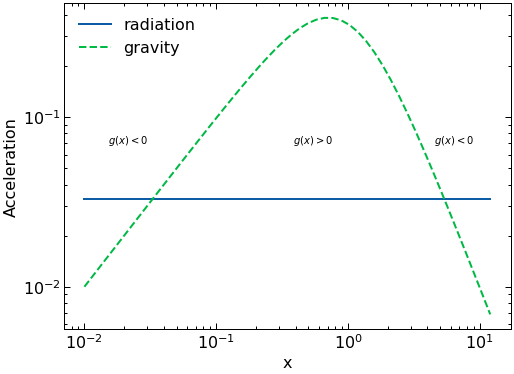

In [298]:
r0 = 7

#first_root = root_scalar(lambda x : rad_normalized(r0) - grav_normalized(x, r0), method='brentq', bracket=(0.01, 1)).root
#second_root = root_scalar(lambda x : rad_normalized(r0) - grav_normalized(x, r0), method='brentq', bracket=(1, 10)).root

#fig, ax = plt.subplots()
plt.loglog(x_range, rad_normalized(r0) * np.ones_like(x_range), label="radiation", linewidth=2)
plt.loglog(x_range, grav_normalized(x_range, r0), label = "gravity", linewidth=2, linestyle='--')
#plt.axvline(first_root, alpha=0.7, linestyle=":", color='grey')
#plt.axvline(second_root, alpha=0.7, linestyle=":", color='grey')
plt.text(0.38, 0.07, r"$g(x) > 0$")
plt.text(4.5, 0.07, r"$g(x) < 0$")
plt.text(0.015, 0.07, r"$g(x) < 0$")

plt.xlabel("x")
plt.ylabel("Acceleration")
plt.legend()
#plt.savefig("radiation_vs_gravity.pdf", bbox_to_inches=True, dpi=300)

In [299]:
def F(x, wp, gaspfactor=1, mdot=1, r=100):
    #gaspfactor = (1- s/w)
    z = x * r
    #sv = s(r)
    return wp * gaspfactor + g(x,r) - f() * (a(r) / mdot * wp)**alpha

# 5 Regions

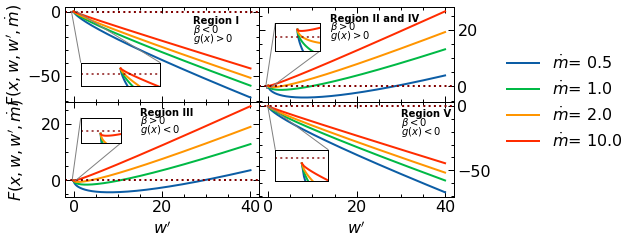

In [300]:
fig, ax = plt.subplots(2,2, sharex=True, figsize=(2*mnras_width, mnras_width))
mdot_range = [0.5, 1, 2, 10]
subsonic_w = -1
supersonic_w  = 0.77


# region 1
axins = zoomed_inset_axes(ax[0,0], 18, loc='lower left', borderpad=1) # zoom-factor: 2.5, location: upper-left
wp_range = np.geomspace(1e-3,40, 5000)
for mdot in mdot_range:
    ax[0,0].plot(wp_range, F(1, wp_range, subsonic_w, mdot=mdot), label = r"$x$= 1, $\dot m$= %d"%mdot)
    axins.plot(wp_range, F(1, wp_range, subsonic_w, mdot=mdot), label = r"$x$= 1, $\dot m$= %d"%mdot)
axins.axhline(0, color="maroon", linestyle=":", alpha=0.7)
mark_inset(ax[0,0], axins, loc1=2, loc2=1, fc="none", ec="0.5")
x1, x2, y1, y2 = -0.5, 0.5, -0.5, 0.5 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
axins.get_xaxis().set_ticks([])
axins.get_yaxis().set_ticks([])
#ax[0,0].legend(loc="upper right", borderpad=1.5)
ax[0,0].axhline(0, color="maroon", linestyle=":")
ax[0,0].text(27, -9, "Region I", weight="bold")
ax[0,0].text(27, -16, r"$\beta < 0$")
ax[0,0].text(27, -23, r"$g(x)>0$")

# region 2 and 4
axins = zoomed_inset_axes(ax[0,1], 10, loc='upper left', borderpad=1) # zoom-factor: 2.5, location: upper-left
wp_range = np.linspace(0,40, 5000)
for mdot in mdot_range:
    ax[0,1].plot(wp_range, F(1, wp_range, supersonic_w, mdot=mdot), label = r"$x$= 1, $\dot m$= %d"%mdot)
    axins.plot(wp_range, F(1, wp_range, supersonic_w, mdot=mdot), label = r"$x$= 1, $\dot m$= %d"%mdot)
    
axins.axhline(0, color="maroon", linestyle=":", alpha=0.7)
mark_inset(ax[0,1], axins, loc1=2, loc2=4, fc="none", ec="0.5")
x1, x2, y1, y2 = -0.5, 0.5, -0.5, 0.5 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
axins.get_xaxis().set_ticks([])
axins.get_yaxis().set_ticks([])
#ax[0,1].legend(loc='upper center', fontsize=12)
ax[0,1].axhline(0, color="maroon", linestyle=":")
ax[0,1].yaxis.tick_right()
ax[0,1].yaxis.set_ticks_position('both')

ax[0,1].text(14, 23, "Region II and IV", weight="bold")
ax[0,1].text(14, 20, r"$\beta > 0$")
ax[0,1].text(14, 17, r"$g(x)>0$")

# Region 3
axins = zoomed_inset_axes(ax[1,0], 15, loc='upper left', borderpad = 1) # zoom-factor: 2.5, location: upper-left
wp_range = np.linspace(0,40, 5000)
x=10
for mdot in mdot_range:
    ax[1,0].plot(wp_range, F(x, wp_range, supersonic_w, mdot=mdot), label = r"$x$= 1, $\dot m$= %d"%mdot)
    axins.plot(wp_range, F(x, wp_range,  supersonic_w, mdot=mdot), label = r"$x$= 1, $\dot m$= %d"%mdot)
    
axins.axhline(0, color="maroon", linestyle=":", alpha=0.7)
mark_inset(ax[1,0], axins, loc1=2, loc2=4, fc="none", ec="0.5")
x1, x2, y1, y2 = -0.3, 0.3, -0.3, 0.3 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
axins.get_xaxis().set_ticks([])
axins.get_yaxis().set_ticks([])
#ax[1,0].legend(loc='upper center', fontsize=12)
ax[1,0].axhline(0, color="maroon", linestyle=":")
ax[1,0].text(15, 23, "Region III", weight="bold")
ax[1,0].text(15, 20, r"$\beta > 0$")
ax[1,0].text(15, 17, r"$g(x)<0$")

# Region 5

axins = zoomed_inset_axes(ax[1,1], 60, loc='lower left', borderpad=1) # zoom-factor: 2.5, location: upper-left
wp_range = np.linspace(0,40, 5000)
x=10
wfactor = -0.77
for mdot in mdot_range:
    ax[1,1].plot(wp_range, F(x, wp_range, subsonic_w, mdot=mdot), label = r"$\dot m$= %.1f"%mdot)
    axins.plot(wp_range, F(x, wp_range, subsonic_w, mdot=mdot), label = r"$\dot m$= %.1f"%mdot)
    
axins.axhline(0, color="maroon", linestyle=":", alpha=0.7)
mark_inset(ax[1,1], axins, loc1=2, loc2=1, fc="none", ec="0.5")
x1, x2, y1, y2 = -0.1, 0.1, -0.3, 0.1 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
axins.get_xaxis().set_ticks([])
axins.get_yaxis().set_ticks([])
#ax[1,1].legend(loc='upper right', fontsize=12, borderpad=1.5)
ax[1,1].axhline(0, color="maroon", linestyle=":")
ax[1,1].yaxis.tick_right()
ax[1,1].yaxis.set_ticks_position('both')
ax[1,1].legend(loc='center left', bbox_to_anchor=(1.2, 1))

ax[1,1].text(30, -8, "Region V", weight="bold")
ax[1,1].text(30, -15, r"$\beta < 0$")
ax[1,1].text(30, -22, r"$g(x)<0$")


# labels

ax[1,0].set_xlabel(r"$w'$")
ax[1,1].set_xlabel(r"$w'$")

ax[1,0].set_ylabel(r"$F(x, w, w', \dot m)$", labelpad=15)
ax[0,0].set_ylabel(r"$F(x, w, w', \dot m)$")


plt.subplots_adjust(wspace=0, hspace=0)
#fig.savefig("regions.pdf", bbox_inches="tight")

In [305]:
def disk_height_kernel(z, r_0):
    rad_acc = radiative_acc(r_0)
    grav = gravity_acc(z, r_0)
    return rad_acc - grav

def disk_height(r_0):
    return optimize.brentq(lambda z: disk_height_kernel(z, r_0), 0, r_0)

def critical_point_height(r_0):
    return r_0 / np.sqrt(2)

In [306]:
disk_height_kernel(100, 7)

34848.2671718874

In [307]:
r_range = np.linspace(7,1000)

In [309]:
disk_heights = []
crit_heights = []
for r in r_range:
    disk_heights.append(disk_height(r))
    crit_heights.append(critical_point_height(r))

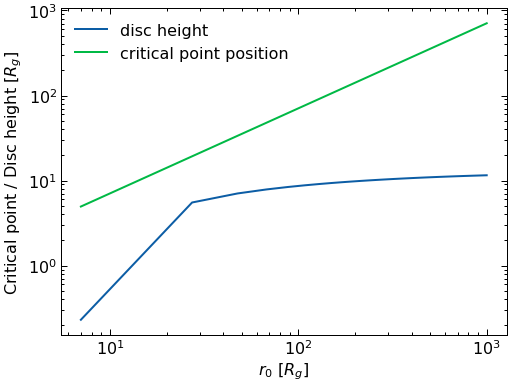

In [314]:
plt.loglog(r_range, disk_heights, label="disc height")
plt.loglog(r_range, crit_heights, label="critical point position")
plt.xlabel(r"$r_0$ [$R_g$]")
plt.ylabel(r"Critical point / Disc height [$R_g$]")
plt.legend()

# Nozzle

In [311]:
# -> Julia

In [318]:
x_range = np.linspace(0,10)

<ipython-input-315-c9ce9520b118>:42: RuntimeWarning: invalid value encountered in power
  ret *= f()**(1/alpha) * a(r) / (g(x,r)**((1-alpha)/alpha))


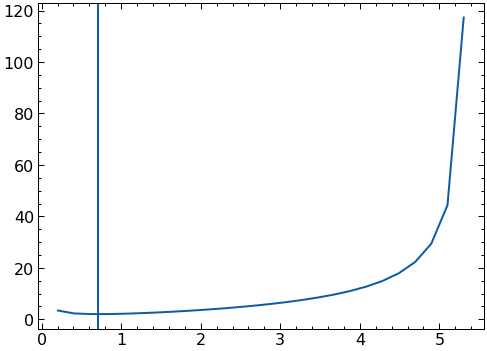

In [326]:
r = 7
plt.plot(x_range, nozzle(x_range,r ))
plt.axvline(1/np.sqrt(2))